In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hadicanmunis","key":"ab9a77c9c63766691e80ccac2ffc82ff"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d hadicanmunis/plantvillage

100% 355M/355M [00:17<00:00, 22.5MB/s]
100% 355M/355M [00:17<00:00, 21.9MB/s]


In [4]:
!unzip -qq plantvillage.zip

In [5]:
import os, shutil, pathlib
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

In [6]:
train_dir = pathlib.Path("/content/Plant_leave_diseases_dataset_without_augmentation/train")
test_dir = pathlib.Path("/content/Plant_leave_diseases_dataset_without_augmentation/test")

In [7]:
from tensorflow.keras.utils import image_dataset_from_directory

image_size = (256, 256)
batch_size = 64

train_ds, val_ds = image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    validation_split=0.1,
    subset="both",
    image_size=image_size,
    seed=1337,
    batch_size=batch_size,
)

test_ds = image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=image_size,
    batch_size=batch_size)

Found 18195 files belonging to 15 classes.
Using 16376 files for training.
Using 1819 files for validation.
Found 4591 files belonging to 15 classes.


In [8]:
for data_batch, labels_batch in train_ds:
     print("data batch shape:", data_batch.shape)
     print("labels batch shape:", labels_batch.shape)
     break

data batch shape: (64, 256, 256, 3)
labels batch shape: (64, 15)


In [9]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomBrightness(0.2),
        layers.RandomContrast(0.1),
    ]
)

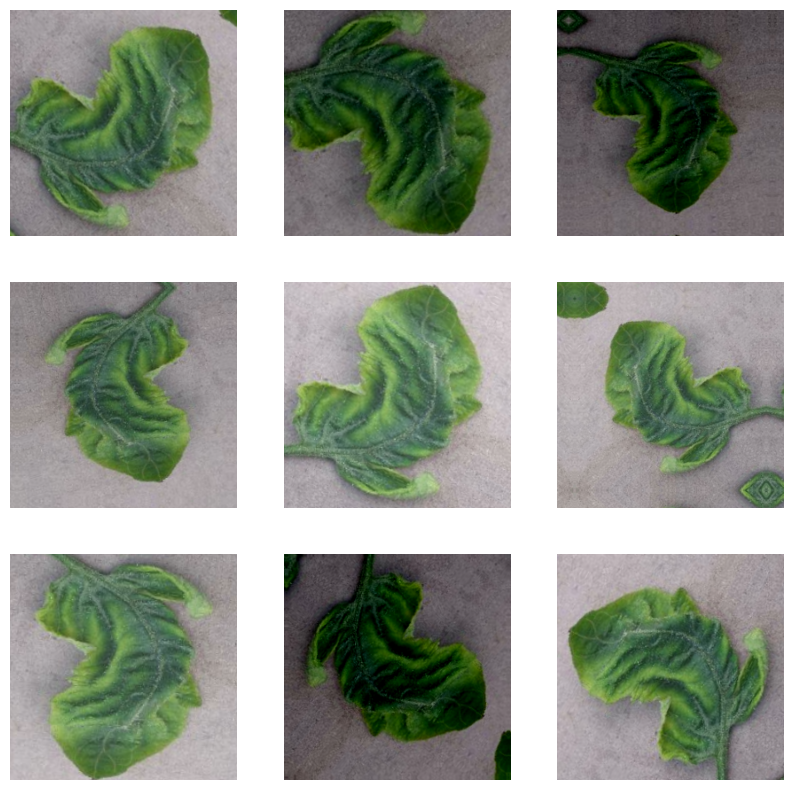

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation="relu")(x)
outputs = layers.Dense(15, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                        

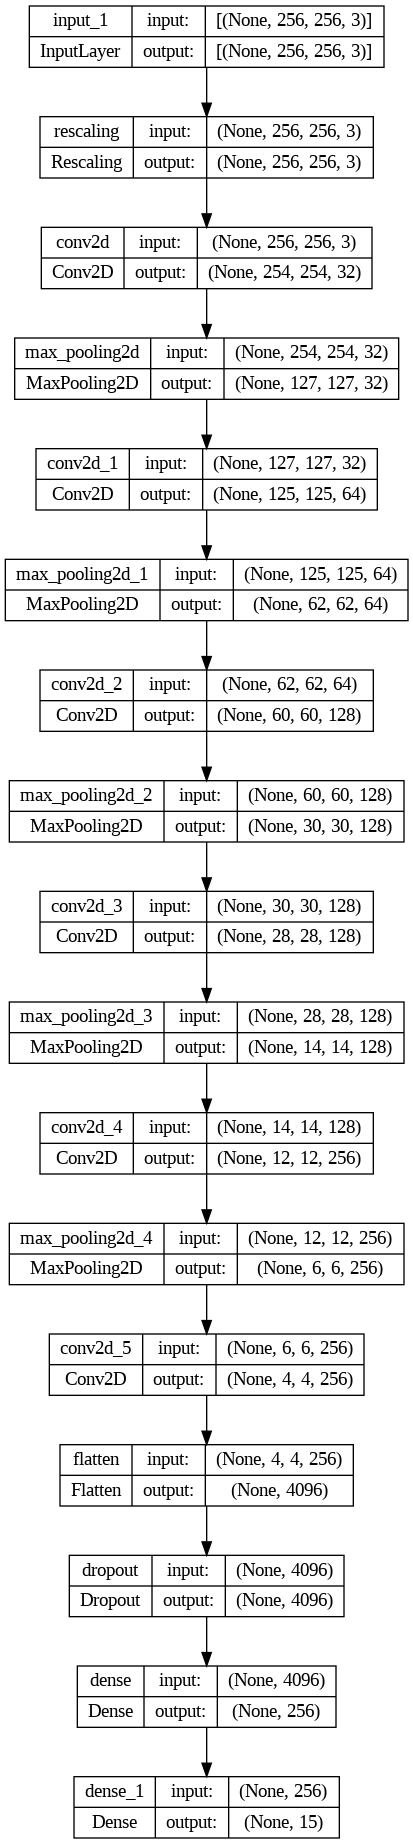

In [13]:
keras.utils.plot_model(model, show_shapes=True)

In [14]:
model.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [15]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="first_baseline_model_2.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=callbacks)

Epoch 1/100
256/256 [==============================] - 18s 44ms/step - loss: 2.1647 - accuracy: 0.3401 - val_loss: 1.7683 - val_accuracy: 0.4200
Epoch 2/100
256/256 [==============================] - 9s 35ms/step - loss: 1.2321 - accuracy: 0.6023 - val_loss: 0.8030 - val_accuracy: 0.7163
Epoch 3/100
256/256 [==============================] - 9s 35ms/step - loss: 0.8047 - accuracy: 0.7375 - val_loss: 1.6822 - val_accuracy: 0.5789
Epoch 4/100
256/256 [==============================] - 9s 35ms/step - loss: 0.5676 - accuracy: 0.8094 - val_loss: 0.5628 - val_accuracy: 0.8197
Epoch 5/100
256/256 [==============================] - 9s 35ms/step - loss: 0.4495 - accuracy: 0.8508 - val_loss: 0.3284 - val_accuracy: 0.8840
Epoch 6/100
256/256 [==============================] - 9s 35ms/step - loss: 0.3468 - accuracy: 0.8867 - val_loss: 0.2557 - val_accuracy: 0.9093
Epoch 7/100
256/256 [==============================] - 9s 35ms/step - loss: 0.2894 - accuracy: 0.9033 - val_loss: 0.3742 - val_accuracy

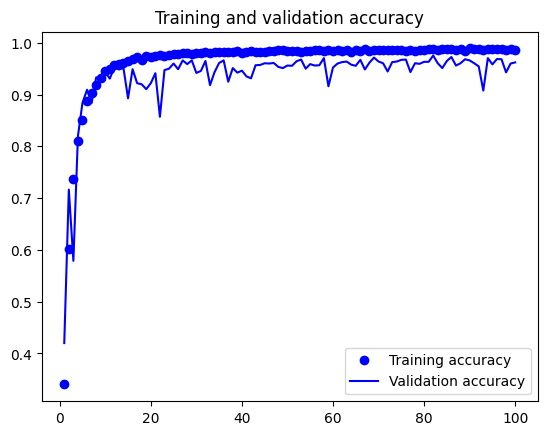

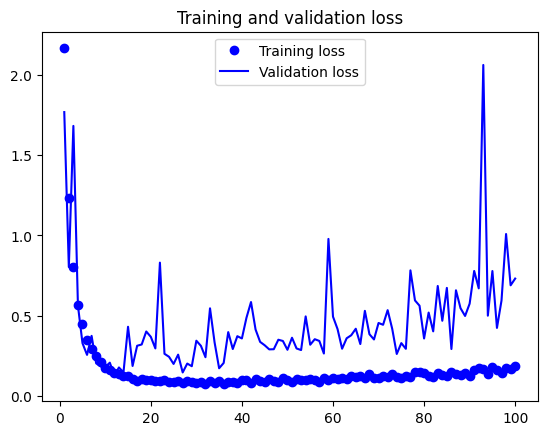

In [16]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [18]:
test_model = keras.models.load_model("first_baseline_model_2.keras")
test_loss, test_acc = test_model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")

72/72 [==============================] - 2s 28ms/step - loss: 0.1678 - accuracy: 0.9497
Test accuracy: 0.950
